In [1]:
#Using these imports that are the necessary libraries to start with the EDA
import pandas as pd 
import pandas_datareader as web 
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

#Relax the display limits on columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv')# Using pandas to read our data and transforming it into a dataframe

gasConsumption.head(5) #First thing to do is to visualise our df

,Date,Corrib production,Moffat,ROI imports via interconnector,Total
0,01/01/2018,102.065496,71.311111,27.152195,200.528802
1,02/01/2018,101.201763,72.300000,31.378951,204.880714
2,03/01/2018,101.289081,94.022222,51.224061,246.535364
3,04/01/2018,102.011852,128.000000,77.649775,307.661627
4,05/01/2018,101.724944,127.900000,84.766547,314.391491


In [3]:
missingValues = gasConsumption['Total'].isnull().sum()
if missingValues > 0:
    print(f'There are {missingValues} missing values in the time series.')
else:
    print('There are no missing values in the time series.')

There are no missing values in the time series.


In [4]:
gasConsumption = gasConsumption.drop(columns = ['Corrib production', 'Moffat', 'ROI imports via interconnector'])
     #after seeing the dataset a lot of data are decided not to be kept simply because they are not needed

In [5]:
gasConsumption.index = pd.to_datetime(gasConsumption['Date'], format='%d/%m/%Y')
del gasConsumption['Date']

In [6]:
gasConsumption.head()

,Total
Date,
2018-01-01,200.528802
2018-01-02,204.880714
2018-01-03,246.535364
2018-01-04,307.661627
2018-01-05,314.391491


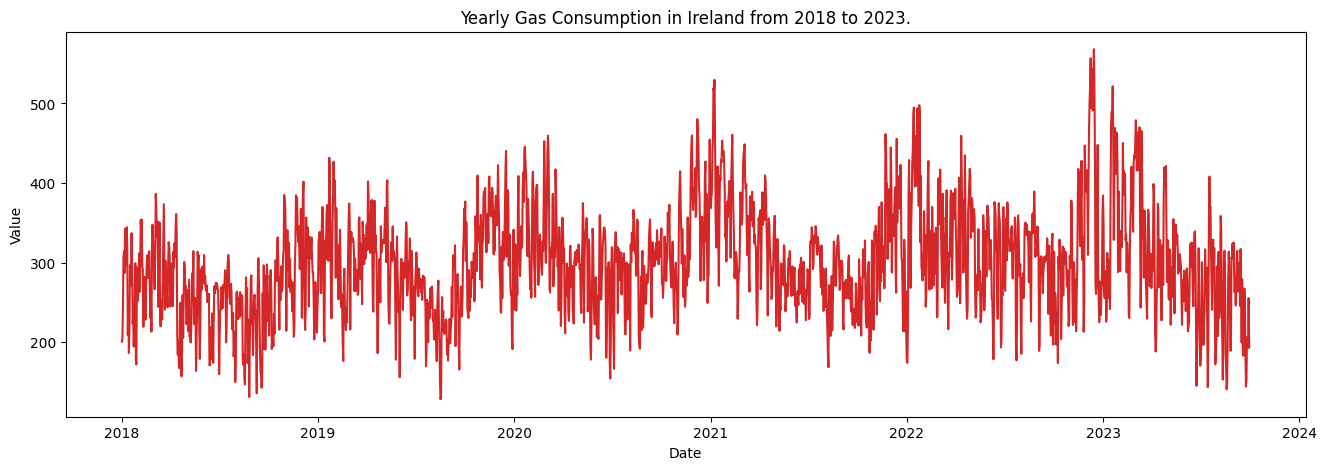

In [7]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(gasConsumption, x=gasConsumption.index, y=gasConsumption.Total, title='Yearly Gas Consumption in Ireland from 2018 to 2023.') 

In [8]:
print(gasConsumption.columns)


Index(['Total'], dtype='object')


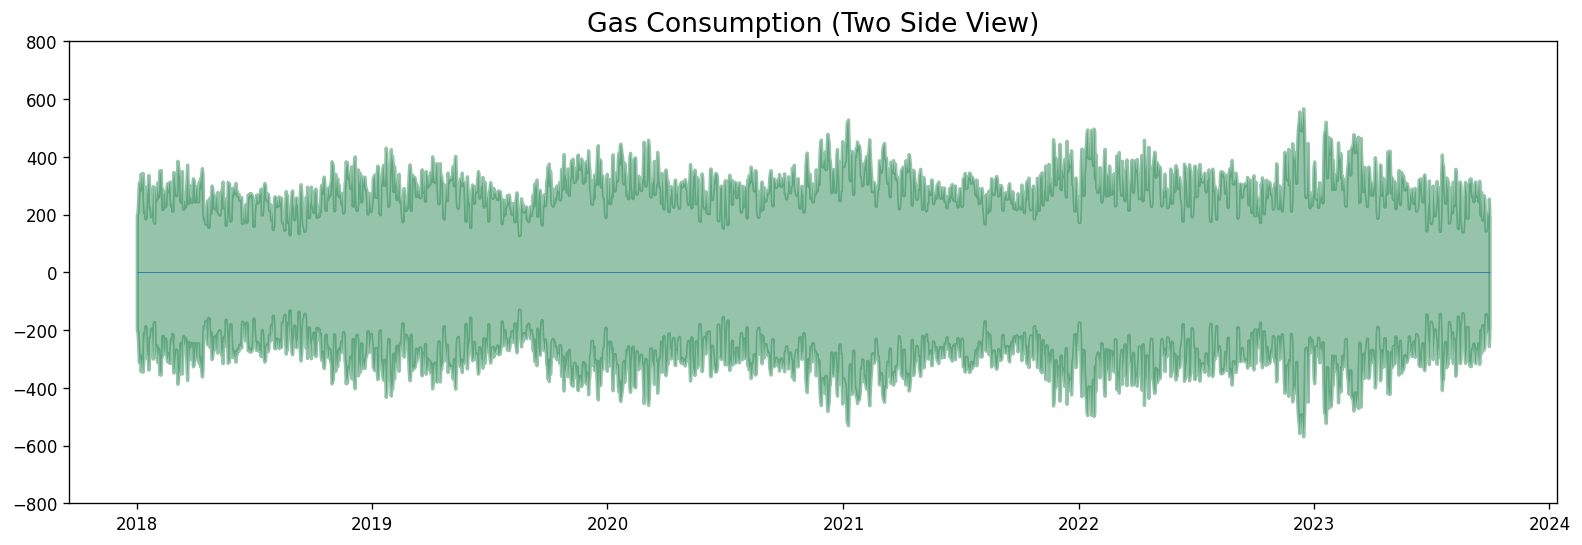

In [9]:
import numpy as np
x = gasConsumption.index
y1 = gasConsumption['Total']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Gas Consumption (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(gasConsumption.index), xmax=np.max(gasConsumption.index), linewidth=.5)
plt.show()

In [10]:
print(gasConsumption.columns)

Index(['Total'], dtype='object')


In [11]:
gasConsumption.shape #Using .shape to see the size of the dataframe, the rows and columns.


(2099, 1)

In [12]:
gasConsumption.info() #Using .info to see the content of the data frame, useful to identify my nulls, types, and names of columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2099 entries, 2018-01-01 to 2023-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   2099 non-null   float64
dtypes: float64(1)
memory usage: 32.8 KB


In [14]:
gasConsumption.describe() #Summary of the statistical properties

,Total
count,2099.000000
mean,299.502497
std,66.226037
min,128.260467
25%,256.356077
50%,296.072343
75%,337.168651
max,568.131933


In [16]:
duplicate_rows_df = gasConsumption[gasConsumption.duplicated()]
print("Duplicated rows: ", duplicate_rows_df)

Duplicated rows:  Empty DataFrame
Columns: [Total]
Index: []


In [17]:
duplicate_rows_df = gasConsumption[gasConsumption.duplicated()]
print("Duplicated rows: ", duplicate_rows_df)


Duplicated rows:  Empty DataFrame
Columns: [Total]
Index: []


In [ ]:
import matplotlib as mpl
gasConsumption['year'] = [d.year for d in gasConsumption.index]
gasConsumption['month'] = [d.strftime('%b') for d in gasConsumption.index]
years = gasConsumption['year'].unique()


np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Total', data=gasConsumption, ax=axes[0], palette=mycolors)
sns.boxplot(x='month', y='Total', data=gasConsumption.loc[~gasConsumption.year.isin([2018, 2023]), :], palette=mycolors)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


fig, axes = plt.subplots(1, 3, figsize=(20, 4), dpi=100)


gasConsumption.groupby(gasConsumption.index.year)['Total'].mean().plot(title='Trend Only', legend=False, ax=axes[0])


gasConsumption.groupby(gasConsumption.index.month)['Total'].mean().plot(title='Seasonality Only', legend=False, ax=axes[1])
gasConsumption['Total'].plot(title='Trend and Seasonality', legend=False, ax=axes[2])

plt.show()



In [ ]:
sns.set()
plt.ylabel('Total')
plt.xlabel ('Date')
plt.xticks(rotation =45)
plt.plot(gasConsumption.index, gasConsumption [ 'Total'],)
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
%matplotlib inline


# Multiplicative Decomposition 
result_mul = seasonal_decompose(gasConsumption['Total'], model='multiplicative', extrapolate_trend='freq')



# Plot
plt.rcParams.update({'figure.figsize': (25,25)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)




In [ ]:
# Additive Decomposition
result_add = seasonal_decompose(gasConsumption['Total'], model='additive', extrapolate_trend='freq')
result_add.plot().suptitle('Additive Decompose', fontsize=22)

In [ ]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

In [ ]:
print(gasConsumption.dtypes)



In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv')

gasConsumption['Date'] = pd.to_datetime(gasConsumption['Date'], format='%d/%m/%Y')
#del gasConsumption['Date']
# ADF Test
result = adfuller(gasConsumption.Total.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(gasConsumption.Total.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
    

In [ ]:
gasConsumption.head()

In [ ]:
from scipy import signal
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv',parse_dates=['Date'])


detrended = signal.detrend(gasConsumption.Total.values)
plt.plot(detrended)
plt.title('Gas Consumption detrended by subtracting the least squares fit', fontsize=16)

In [ ]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv')
gasConsumption.index = pd.to_datetime(gasConsumption['Date'], format='%d/%m/%Y')

result_mul = seasonal_decompose(gasConsumption['Total'], model='multiplicative', extrapolate_trend='freq')
detrended = gasConsumption.Total.values - result_mul.trend
plt.plot(detrended)
plt.title('Gas Consumption detrended by subtracting the trend component', fontsize=16)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Subtracting the Trend Component.
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv')
gasConsumption.index = pd.to_datetime(gasConsumption['Date'], format='%d/%m/%Y')
# Time Series Decomposition
result_mul = seasonal_decompose(gasConsumption['Total'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = gasConsumption['Total'].values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Gas Consumption Deseasonalized', fontsize=16)
plt.plot()


# test for seasonality of a time series

In [ ]:
from pandas.plotting import autocorrelation_plot
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv')

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(gasConsumption['Total'].tolist())


# Autocorrelation and partial autocorrelation functions

In [ ]:

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv')


# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(gasConsumption.Total.tolist(), lags=50, ax=axes[0])
plot_pacf(gasConsumption.Total.tolist(), lags=50, ax=axes[1])

In [ ]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Import

# Plot

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(gasConsumption.Total, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Gas Consumption', y=1.05)    
plt.show()

# Forecastability

In [ ]:
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))


print(ApEn(gasConsumption.Total, m=2, r=0.2*np.std(gasConsumption.Total)))   
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) 
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     

In [ ]:
# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))


print(SampEn(gasConsumption.Total, m=2, r=0.2*np.std(gasConsumption.Total)))   
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      

# Granger Causality

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv', parse_dates=['Date'], index_col='Date')
gasConsumption.index = pd.to_datetime(gasConsumption.index, format='%d/%m/%Y')
gasConsumption['year'] = [d.year for d in gasConsumption.index]
grangercausalitytests(gasConsumption[['Total', 'year']], maxlag=2)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv', parse_dates=['Date'], index_col='Date')
gasConsumption.index = pd.to_datetime(gasConsumption.index, format='%d/%m/%Y')
gasConsumption['month'] = [d.month for d in gasConsumption.index]
grangercausalitytests(gasConsumption[['Total', 'month']], maxlag=2)

In [ ]:
gasConsumption.head()

In [ ]:
gasConsumption = pd.read_csv('2023-Q3-Daily-supply.csv')
gasConsumption.index = pd.to_datetime(gasConsumption['Date'], format='%d/%m/%Y')
del gasConsumption['Date']
gasConsumption = gasConsumption.drop(columns = ['Corrib production', 'Moffat', 'ROI imports via interconnector'])
train =gasConsumption[gasConsumption.index < pd.to_datetime('29-09-2022',format = '%d-%m-%Y')]
test =gasConsumption[gasConsumption.index >= pd.to_datetime('29-09-2022',format = '%d-%m-%Y')]

In [ ]:
plt.plot(train,color ='black')
plt.plot(test,color = 'red')
plt.ylabel('Gas Consumption, Total')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title ('Train/Test split for Gas Consumption Data')
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = train['Total']

# Fit SARIMA model
SARIMA_model = SARIMAX(y, order=(1, 0, 1))
SARIMA_model = SARIMA_model.fit()

# Forecast
y_pred = SARIMA_model.get_forecast(steps=len(test.index))
y_pred_df = y_pred.conf_int(alpha=0.05) 
y_pred_df["Predictions"] = SARIMA_model.predict(start=y_pred_df.index[0], 
                                                end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_SARIMA = y_pred_df["Predictions"]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, color="black", label='Training')
plt.plot(test, color="red", label='Testing')
plt.plot(y_pred_out_SARIMA, color='green', label='SARIMA Predictions')
plt.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2)
plt.ylabel('Gas Consumption Total')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gas Consumption Data")
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA


y = train['Total']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], 
                                             end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARMA = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Gas Consumption Total')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gas Consumption Data")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.legend()
plt.show()

In [ ]:
#Determine rolling statistics
gasConsumption["rolling_avg"] = gasConsumption["Total"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
gasConsumption["rolling_std"] = gasConsumption["Total"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(gasConsumption["Total"], color='#379BDB', label='Original')
plt.plot(gasConsumption["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(gasConsumption["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#pip install pmdarima


In [ ]:
import pmdarima as pm
ARIMA_model = pm.auto_arima(gasConsumption['Total'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
def forecast(ARIMA_model, periods=12):
  
        # Forecast
        n_periods = periods
        fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = pd.date_range(gasConsumption.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

        # Plot
        plt.figure(figsize=(15,7))
        plt.plot(gasConsumption.index, gasConsumption["Total"], color='#1f76b4', label='Actual')
        plt.plot(index_of_fc, fitted, color='darkgreen', label='Forecast')
        plt.fill_between(index_of_fc, 
                         confint[:, 0], 
                         confint[:, 1], 
                         color='k', alpha=.15)

        plt.title("ARIMA/SARIMA - Forecast of Gas Consumption")
        plt.legend()
        plt.show()

    

# Call the forecast function
forecast(ARIMA_model)


In [ ]:
try:
    SARIMA_model = pm.auto_arima(gasConsumption['Total'], start_p=1, start_q=1,
                                 test='adf',
                                 max_p=3, max_q=3, 
                                 m=12, #12 is the frequency of the cycle
                                 start_P=0, 
                                 seasonal=True, #set to seasonal
                                 d=None, 
                                 D=1, #order of the seasonal differencing
                                 trace=False,
                                 error_action='ignore',  
                                 suppress_warnings=True, 
                                 stepwise=True)
except Exception as e:
    print("An error occurred:", e)


In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
forecast(SARIMA_model)

Epoch 1/50
210/210 [==============================] - 0s 406us/step - loss: 94022.4922
Epoch 2/50
210/210 [==============================] - 0s 351us/step - loss: 93896.9922
Epoch 3/50
210/210 [==============================] - 0s 345us/step - loss: 93771.8203
Epoch 4/50
210/210 [==============================] - 0s 340us/step - loss: 93646.6484
Epoch 5/50
210/210 [==============================] - 0s 349us/step - loss: 93521.6250
Epoch 6/50
210/210 [==============================] - 0s 337us/step - loss: 93396.8047
Epoch 7/50
210/210 [==============================] - 0s 354us/step - loss: 93272.0781
Epoch 8/50
210/210 [==============================] - 0s 375us/step - loss: 93147.4375
Epoch 9/50
210/210 [==============================] - 0s 343us/step - loss: 93022.9297
Epoch 10/50
210/210 [==============================] - 0s 346us/step - loss: 92898.5078
Epoch 11/50
210/210 [==============================] - 0s 339us/step - loss: 92774.2109
Epoch 12/50
210/210 [====================